# Lab2 EEGNet

In [1]:
import os
import torch
print(torch.__version__)
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from dataloader import read_bci_data

1.4.0
cuda


## TensorDataset & DataLoader

In [2]:
X_train,y_train,X_test,y_test=read_bci_data()
dataset=TensorDataset(torch.from_numpy(X_train),torch.from_numpy(y_train))
loader_train=DataLoader(dataset,batch_size=64)
dataset=TensorDataset(torch.from_numpy(X_test),torch.from_numpy(y_test))
loader_test=DataLoader(dataset,batch_size=64)
print(f'test dataset:\n{dataset[:3]}')

(1080, 1, 2, 750) (1080,) (1080, 1, 2, 750) (1080,)
test dataset:
(tensor([[[[ -8.3359,  -8.7829,  -9.3748,  ...,  -2.1328,  -2.8224,  -2.0885],
          [-10.6524,  -8.4476,  -5.9331,  ...,   0.5607,  -4.1266,  -8.1379]]],


        [[[ -1.6904,  -3.2816,  -3.6523,  ...,   4.0093,   0.7018,   0.7155],
          [  3.4033,   2.0698,  -1.6959,  ...,   7.7458,   3.5498,   3.7207]]],


        [[[ -2.6835,  -0.4836,   1.9848,  ...,  -3.9513,   0.4729,   5.2923],
          [  2.6602,   3.9587,   4.9871,  ...,  -0.6675,  -0.2266,   0.0633]]]],
       dtype=torch.float64), tensor([1., 0., 1.], dtype=torch.float64))


sample_id:936


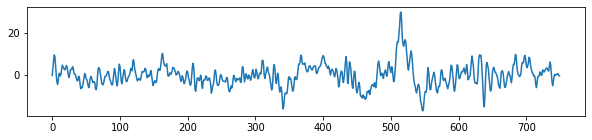

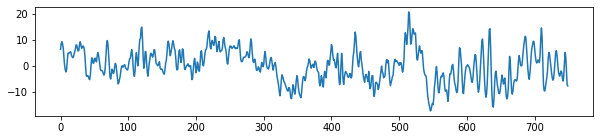

In [3]:
randi=int(np.random.randint(0,X_train.shape[0],1))
print(f'sample_id:{randi}')
plt.figure(figsize=(10,2))
plt.plot(X_train[randi,0,0])
plt.figure(figsize=(10,2))
plt.plot(X_train[randi,0,1])

## Model
![eegnet](eegnet.png)  

In [4]:
class EEGNet(nn.Module):
    def __init__(self,activation=nn.ELU()):
        super(EEGNet,self).__init__()
        self.firstconv=nn.Sequential(
            nn.Conv2d(1,16,kernel_size=(1,51),stride=(1,1),padding=(0,25),bias=False),
            nn.BatchNorm2d(16,eps=1e-5,momentum=0.1,affine=True,track_running_stats=True)
        )
        self.depthwiseConv=nn.Sequential(
            nn.Conv2d(16,32,kernel_size=(2,1),stride=(1,1),groups=16,bias=False),
            nn.BatchNorm2d(32,eps=1e-5,momentum=0.1,affine=True,track_running_stats=True),
            activation,
            nn.AvgPool2d(kernel_size=(1,4),stride=(1,4),padding=0),
            nn.Dropout(p=0.25)
        )
        self.seperableConv=nn.Sequential(
            nn.Conv2d(32,32,kernel_size=(1,15),stride=(1,1),padding=(0,7),bias=False),
            nn.BatchNorm2d(32,eps=1e-5,momentum=0.1,affine=True,track_running_stats=True),
            activation,
            nn.AvgPool2d(kernel_size=(1,8),stride=(1,8),padding=0),
            nn.Dropout(p=0.25)
        )
        self.classify=nn.Linear(736,2)
    def forward(self,X):
        out=self.firstconv(X)
        out=self.depthwiseConv(out)
        out=self.seperableConv(out)
        out=out.view(out.shape[0],-1)
        out=self.classify(out)
        return out

## Train
__loss function:__ cross entropy  
__optimizer:__ adam  
__learning rate:__ 0.001  
__epoch:__ 300  
__batch_size:__ 64  
__activation fuction:__ ReLU,LeakyReLU,ELU  

In [5]:
Loss=nn.CrossEntropyLoss()
lr=0.001
epochs=300

In [6]:
def train_with_different_activation(loader_train,loader_test,activations,device):
    """
    Args:
        loader_train: training dataloader
        loader_test: testing dataloader
        activations: {ReLU,LeakyReLU,ELU} pytorch layer
        device: pytorch device gpu,cpu
    Return:
        dataframe: with column 'epoch','ReLU_train','ReLU_test','LeakyReLU_train'...
    """
    df=pd.DataFrame()
    df['epoch']=range(1,epochs+1)
    for name,activation in activations.items():
        """
        train model with an specific activation function
        """
        model=EEGNet(activation)
        model.to(device)
        optimizer=torch.optim.Adam(model.parameters(),lr=lr)
        acc_train=list()
        acc_test=list()
        for epoch in range(1,epochs+1):
            """
            train
            """
            model.train()
            loss=0
            correct=0
            for idx,(data,target) in enumerate(loader_train):
                data=data.to(device,dtype=torch.float)
                target=target.to(device,dtype=torch.long) #target type has to be 'long'
                predict=model(data)
                loss+=Loss(predict,target)
                correct+=predict.max(dim=1)[1].eq(target).cpu().sum()
                """
                update
                """
                optimizer.zero_grad()
                loss.backward(retain_graph=True)
                optimizer.step()
            loss/=len(loader_train.dataset)
            correct=100.*correct/len(loader_train.dataset)
            print(f'epcoh{epoch:>3d}  loss:{loss:.4f}  acc:{correct:.1f}%')
            acc_train.append(correct)
            """
            test
            """
            model.eval()
            correct=0
            for idx,(data,target) in enumerate(loader_test):
                data=data.to(device,dtype=torch.float)
                target=target.to(device,dtype=torch.long)
                predict=model(data)
                correct+=predict.max(dim=1)[1].eq(target).cpu().sum()
            correct=100.*correct/len(loader_test.dataset)
            acc_test.append(correct)
        df[name+'_train']=acc_train
        df[name+'_test']=acc_test
        torch.save(model.state_dict(),os.path.join('eeg models',name+'.pt'))
    return df

In [7]:
activations={'ReLU':nn.ReLU(),'LeakyReLU':nn.LeakyReLU(),'ELU':nn.ELU()}
df=train_with_different_activation(loader_train,loader_test,activations,device)

epcoh  1  loss:0.0118  acc:52.0%
epcoh  2  loss:0.0133  acc:59.8%
epcoh  3  loss:0.0240  acc:51.0%
epcoh  4  loss:0.0133  acc:67.0%
epcoh  5  loss:0.0112  acc:70.6%
epcoh  6  loss:0.0117  acc:67.8%
epcoh  7  loss:0.0083  acc:73.5%
epcoh  8  loss:0.0083  acc:73.1%
epcoh  9  loss:0.0086  acc:73.1%
epcoh 10  loss:0.0082  acc:72.9%
epcoh 11  loss:0.0078  acc:75.6%
epcoh 12  loss:0.0076  acc:76.5%
epcoh 13  loss:0.0078  acc:74.7%
epcoh 14  loss:0.0081  acc:75.5%
epcoh 15  loss:0.0080  acc:74.3%
epcoh 16  loss:0.0077  acc:76.7%
epcoh 17  loss:0.0072  acc:76.4%
epcoh 18  loss:0.0074  acc:76.9%
epcoh 19  loss:0.0081  acc:75.7%
epcoh 20  loss:0.0086  acc:71.9%
epcoh 21  loss:0.0085  acc:74.8%
epcoh 22  loss:0.0076  acc:75.4%
epcoh 23  loss:0.0072  acc:76.9%
epcoh 24  loss:0.0072  acc:78.2%
epcoh 25  loss:0.0083  acc:73.2%
epcoh 26  loss:0.0100  acc:72.4%
epcoh 27  loss:0.0092  acc:71.9%
epcoh 28  loss:0.0078  acc:76.6%
epcoh 29  loss:0.0074  acc:78.0%
epcoh 30  loss:0.0089  acc:73.5%
epcoh 31  

epcoh250  loss:0.0016  acc:96.5%
epcoh251  loss:0.0015  acc:97.1%
epcoh252  loss:0.0013  acc:97.2%
epcoh253  loss:0.0015  acc:96.7%
epcoh254  loss:0.0015  acc:96.5%
epcoh255  loss:0.0021  acc:94.9%
epcoh256  loss:0.0013  acc:96.9%
epcoh257  loss:0.0015  acc:96.6%
epcoh258  loss:0.0019  acc:95.8%
epcoh259  loss:0.0016  acc:95.9%
epcoh260  loss:0.0016  acc:96.8%
epcoh261  loss:0.0012  acc:97.4%
epcoh262  loss:0.0013  acc:96.7%
epcoh263  loss:0.0012  acc:97.4%
epcoh264  loss:0.0011  acc:97.8%
epcoh265  loss:0.0012  acc:97.4%
epcoh266  loss:0.0012  acc:97.6%
epcoh267  loss:0.0012  acc:96.7%
epcoh268  loss:0.0012  acc:97.5%
epcoh269  loss:0.0011  acc:97.8%
epcoh270  loss:0.0010  acc:98.1%
epcoh271  loss:0.0010  acc:98.6%
epcoh272  loss:0.0012  acc:98.0%
epcoh273  loss:0.0014  acc:96.8%
epcoh274  loss:0.0012  acc:97.8%
epcoh275  loss:0.0013  acc:96.9%
epcoh276  loss:0.0012  acc:97.6%
epcoh277  loss:0.0010  acc:97.8%
epcoh278  loss:0.0011  acc:97.3%
epcoh279  loss:0.0012  acc:97.3%
epcoh280  

epcoh199  loss:0.0022  acc:94.1%
epcoh200  loss:0.0023  acc:94.7%
epcoh201  loss:0.0015  acc:96.7%
epcoh202  loss:0.0015  acc:96.7%
epcoh203  loss:0.0019  acc:95.6%
epcoh204  loss:0.0016  acc:96.2%
epcoh205  loss:0.0018  acc:95.9%
epcoh206  loss:0.0018  acc:96.0%
epcoh207  loss:0.0017  acc:96.2%
epcoh208  loss:0.0015  acc:96.8%
epcoh209  loss:0.0017  acc:96.6%
epcoh210  loss:0.0021  acc:95.4%
epcoh211  loss:0.0018  acc:95.8%
epcoh212  loss:0.0017  acc:96.2%
epcoh213  loss:0.0017  acc:95.6%
epcoh214  loss:0.0017  acc:95.8%
epcoh215  loss:0.0015  acc:96.7%
epcoh216  loss:0.0014  acc:96.8%
epcoh217  loss:0.0015  acc:96.4%
epcoh218  loss:0.0015  acc:96.9%
epcoh219  loss:0.0015  acc:96.8%
epcoh220  loss:0.0018  acc:95.1%
epcoh221  loss:0.0014  acc:96.7%
epcoh222  loss:0.0016  acc:95.6%
epcoh223  loss:0.0018  acc:96.1%
epcoh224  loss:0.0020  acc:94.0%
epcoh225  loss:0.0023  acc:94.4%
epcoh226  loss:0.0023  acc:94.3%
epcoh227  loss:0.0024  acc:93.9%
epcoh228  loss:0.0017  acc:96.1%
epcoh229  

epcoh148  loss:0.0038  acc:91.3%
epcoh149  loss:0.0036  acc:90.8%
epcoh150  loss:0.0034  acc:91.3%
epcoh151  loss:0.0030  acc:92.6%
epcoh152  loss:0.0032  acc:92.8%
epcoh153  loss:0.0033  acc:91.4%
epcoh154  loss:0.0037  acc:90.1%
epcoh155  loss:0.0036  acc:91.7%
epcoh156  loss:0.0036  acc:91.2%
epcoh157  loss:0.0044  acc:89.6%
epcoh158  loss:0.0041  acc:89.9%
epcoh159  loss:0.0035  acc:92.4%
epcoh160  loss:0.0029  acc:91.8%
epcoh161  loss:0.0029  acc:93.1%
epcoh162  loss:0.0037  acc:91.3%
epcoh163  loss:0.0056  acc:87.4%
epcoh164  loss:0.0045  acc:88.1%
epcoh165  loss:0.0051  acc:87.4%
epcoh166  loss:0.0038  acc:90.1%
epcoh167  loss:0.0040  acc:90.9%
epcoh168  loss:0.0030  acc:92.6%
epcoh169  loss:0.0033  acc:91.3%
epcoh170  loss:0.0031  acc:93.1%
epcoh171  loss:0.0027  acc:93.4%
epcoh172  loss:0.0026  acc:93.6%
epcoh173  loss:0.0027  acc:93.4%
epcoh174  loss:0.0026  acc:94.6%
epcoh175  loss:0.0024  acc:94.0%
epcoh176  loss:0.0029  acc:92.5%
epcoh177  loss:0.0027  acc:93.9%
epcoh178  

## Plot

In [8]:
df

,epoch,ReLU_train,ReLU_test,LeakyReLU_train,LeakyReLU_test,ELU_train,ELU_test
0,1,tensor(52.0370),tensor(57.5926),tensor(55.1852),tensor(66.8519),tensor(60.6481),tensor(69.0741)
1,2,tensor(59.8148),tensor(50.2778),tensor(66.1111),tensor(65.3704),tensor(70.0926),tensor(69.0741)
2,3,tensor(51.0185),tensor(69.2593),tensor(59.3519),tensor(67.5000),tensor(67.8704),tensor(67.6852)
3,4,tensor(67.0370),tensor(62.9630),tensor(57.8704),tensor(69.1667),tensor(70.9259),tensor(70.2778)
4,5,tensor(70.5556),tensor(70.8333),tensor(68.6111),tensor(65.8333),tensor(70.6481),tensor(70.4630)
5,6,tensor(67.7778),tensor(70.1852),tensor(69.7222),tensor(70.2778),tensor(73.9815),tensor(69.5370)
6,7,tensor(73.5185),tensor(69.2593),tensor(68.2407),tensor(68.5185),tensor(71.9444),tensor(71.3889)
7,8,tensor(73.1481),tensor(71.6667),tensor(72.3148),tensor(70.3704),tensor(72.4074),tensor(70.9259)
8,9,tensor(73.1481),tensor(71.7593),tensor(72.4074),tensor(70.5556),tensor(74.8148),tensor(70.6481)
9,10,tensor(72.8704),tensor(70.1852),tensor(70.0926),tensor(70.5556),tensor(73.8889),tensor(72.0370)


In [9]:
def plot(dataframe):
    fig=plt.figure(figsize=(10,6))
    for name in dataframe.columns[1:]:
        plt.plot('epoch',name,data=dataframe)
    plt.legend()
    return fig

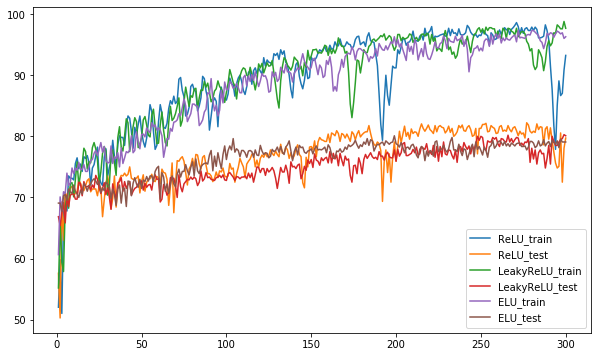

In [10]:
figure=plot(df)
figure.savefig('eeg result.png')